# How to measure a radial velocity

A notebook to support and illustrate ideas in a forthcoming paper.

## Authors:
- **David W Hogg** (NYU) (MPIA) (Flatiron)
- **Megan Bedell** (Flatiron)

## To-Do:
- Make it so all key figures save as pdf files for inclusion in the paper.
- Merge binary-mask regions that overlap? Use a center-of-mass consideration.
- Start experiments that test sensitivities to assumptions.

In [1]:
# imports and initialize seeds, fundamental constants
import numpy as np
import pylab as plt
import scipy.interpolate as interp
np.random.seed(42)
c = 299792458. # m / s
sqrt2pi = np.sqrt(2. * np.pi)

In [2]:
# has to be in its own cell?
plt.rc('figure', figsize=(6.0, 3.6), dpi=150, autolayout=True)
plt.rc('text', usetex=True)

In [3]:
# define high-level parameters, especially including spectrograph parameters
R = 1.35e5 # resolution
SNR = 100. # s/n ratio in the continuum
continuum_ivar = SNR ** 2 # inverse variance of the noise in the continuum
sigma_x = 1. / R # LSF sigma in x units
Delta_x = 1. / (3. * R) # pixel spacing
x_min = 8.70 # minimum ln wavelength
x_max = 8.705 # maximum ln wavelength
lines_per_x = 2.0e4 # mean density (Poisson rate) of lines per unit ln wavelength
ew_max_x = 3.0e-5 # maximum equivalent width in x units
ew_power = 5.0 # power parameter in EW maker

In [4]:
# set up the line list for the true spectral model
x_margin = 1.e6/c # hoping no velocities are bigger than 1000 km/s
x_range = x_max - x_min + 2. * x_margin # make lines in a bigger x range than the data range
nlines = np.random.poisson(x_range * lines_per_x) # set the total number of lines
line_xs = (x_min - x_margin) + x_range * np.random.uniform(size=nlines)

In [5]:
# give those lines equivalent widths from a power-law distribution
line_ews = ew_max_x * np.random.uniform(size=nlines) ** ew_power

In [6]:
# make the synthetic spectrum (spectral expectation), and also add noise

def oned_gaussian(dxs, sigma):
    return np.exp(-0.5 * dxs ** 2 / sigma ** 2) / (sqrt2pi * sigma)

def true_spectrum(xs, doppler, lxs=line_xs, ews=line_ews, sigma=sigma_x):
    """
    """
    return np.exp(-1. * np.sum(ews[None, :] * oned_gaussian(xs[:, None] - doppler - lxs[None, :], sigma), axis=1))

def ivar(ys, continuum_ivar):
    return continuum_ivar / ys

def noisy_true_spectrum(xs, doppler, continuum_ivar):
    """
    """
    ys_true = true_spectrum(xs, doppler)
    y_ivars = ivar(ys_true, continuum_ivar)
    return  ys_true + np.random.normal(size=xs.shape) / np.sqrt(y_ivars), y_ivars

def doppler_information(xs, doppler, continuum_ivar, dx=0.5*Delta_x):
    """
    # Bugs:
    - Horrifying numerical derivative!
    """
    dys_dx = (true_spectrum(xs, doppler + dx) - true_spectrum(xs, doppler - dx)) / (2. * dx)
    y_ivars = ivar(true_spectrum(xs, doppler), continuum_ivar)
    return np.sum(y_ivars * dys_dx ** 2)

In [7]:
# create fake data with true Doppler shifts on a sinusoid of epoch number
xs = np.arange(x_min, x_max, Delta_x)
n_pix = len(xs)
n_epochs = 64
true_dopplers = (3.e4 / c) * np.cos(np.arange(n_epochs) / 8)
ys = np.zeros((n_epochs, n_pix))
y_ivars = np.zeros((n_epochs, n_pix))
y_ivars_empirical = np.zeros((n_epochs, n_pix))
for j in range(n_epochs):
    ys[j], y_ivars[j] = noisy_true_spectrum(xs, true_dopplers[j], continuum_ivar)
    y_ivars_empirical[j] = ivar(ys[j], continuum_ivar)

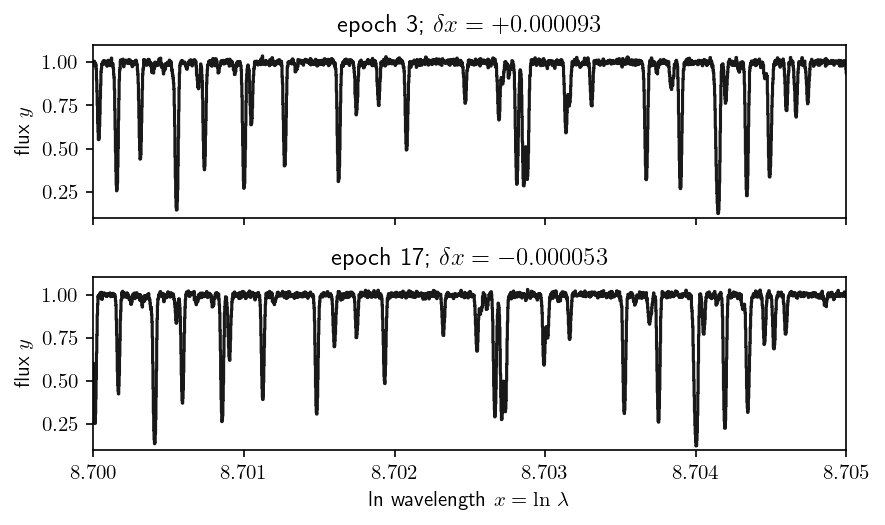

In [52]:
# show some example spectra
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
js = [3, 17]
for j,ax in zip(js,axes):
    ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
    ax.set_title("epoch {}; $\delta x = {:+f}$".format(j, true_dopplers[j]))
    ax.set_ylabel(r"flux $y$")
ax.set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
plt.xlim(x_min, x_max)
plt.ylim(0.1, 1.1)
plt.savefig("data.png")

Text(0.5, 1.0, 'epoch 7; $\\delta x = +0.000064$')

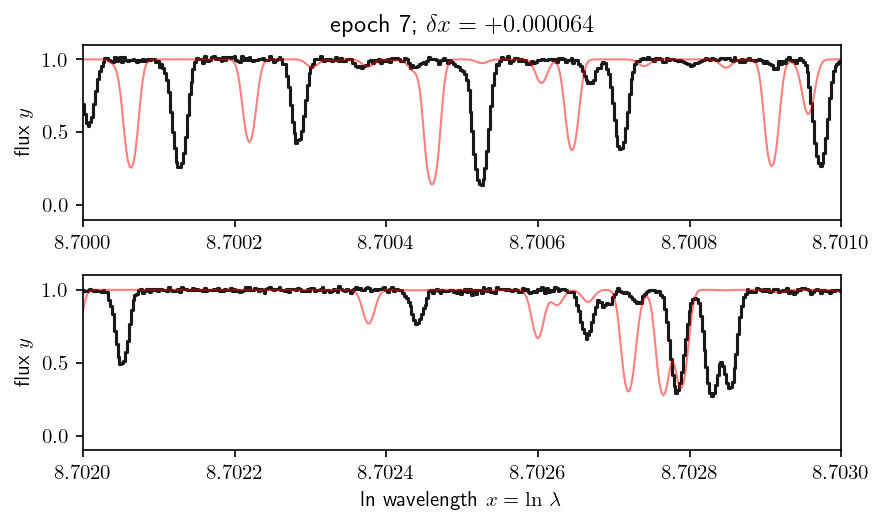

In [9]:
# zoom in on one epoch and compare it to the true template.
j = 7
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(xs, true_spectrum(xs, 0.), "r-", alpha=0.5, lw=1)
    ax.ticklabel_format(useOffset=False)
axes[0].set_xlim(8.700, 8.701)
axes[1].set_xlim(8.702, 8.703)
axes[0].set_ylim(-0.1, 1.1)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("epoch {}; $\delta x = {:+f}$".format(j, true_dopplers[j]))

In [10]:
# define functions to perform CCF-based RV measurement

def cross_correlation(fs, ys, weights, normalize=True):
    if weights is None:
        weights = np.ones_like(ys)
    if normalize:
        return np.sum(weights * ys * fs) / np.sqrt(np.sum(weights * fs * fs))
    return np.sum(weights * ys * fs)

def cross_correlation_function(dopplers, xs, ys, weights=None, normalize=True):
    tys = np.atleast_2d(ys)
    if weights is None:
        weights = np.ones_like(tys)
    I = len(dopplers)
    J = len(tys)
    ccfs = np.zeros((J, I))
    for i,doppler in enumerate(dopplers):
        fs = true_spectrum(xs, doppler)
        for j in range(J):
            ccfs[j,i] = cross_correlation(fs, tys[j], weights[j], normalize=normalize)
    return ccfs

def hogg_parabola_trick(yys, xxs, xplot=None):
    N = len(yys)
    assert len(xxs) == N
    imax = np.argmax(yys)
    if imax < 0.5 or imax > (N - 1.5):
        return np.NaN
    origin = xxs[imax]
    x, y = xxs[imax-1:imax+2] - origin, yys[imax-1:imax+2]
    X = np.vstack((x ** 0, x ** 1, 0.5 * x ** 2)).T
    a = np.linalg.lstsq(X, y, rcond=None)[0]
    if xplot is None:
        return origin - a[1] / a[2]
    X = np.vstack(((xplot-origin) ** 0, (xplot-origin) ** 1, 0.5 * (xplot-origin) ** 2)).T
    return origin - a[1] / a[2], X @ a

def get_all_ccf_rvs(ys, xs, normalize=True):
    """
    ## Bugs:
    - Magic numbers; relies on global variables R, c.
    - Could be sped up enormously by caching the templates it makes over and over!
    """
    J = len(ys)
    assert len(xs) == len(ys[0])
    dopplers = np.arange(-4.e4/c, 4.e4/c, 0.25/R) # MAGIC
    best_dopplers = np.zeros(J)
    ccs = cross_correlation_function(dopplers, xs, ys, normalize=normalize)
    for j in range(J):
        best_dopplers[j] = hogg_parabola_trick(ccs[j], dopplers)
    return best_dopplers

In [11]:
# What's the best doppler information money can buy?
dopplers = np.arange(-4.e4/c, 4.e4/c, 0.25/R)
doppler_infos = np.zeros_like(dopplers)
for i, dd in enumerate(dopplers):
    doppler_infos[i] = doppler_information(xs, dd, continuum_ivar)

In [12]:
# get the CCF RV for one epoch
ccs = cross_correlation_function(dopplers, xs, ys[j])[0]
ddp = np.arange(true_dopplers[j] - 0.5 / R, true_dopplers[j] + 0.5 / R, 0.01 / R)
best_doppler, ccp = hogg_parabola_trick(ccs, dopplers, ddp)
print(best_doppler)

6.4153263135459e-05


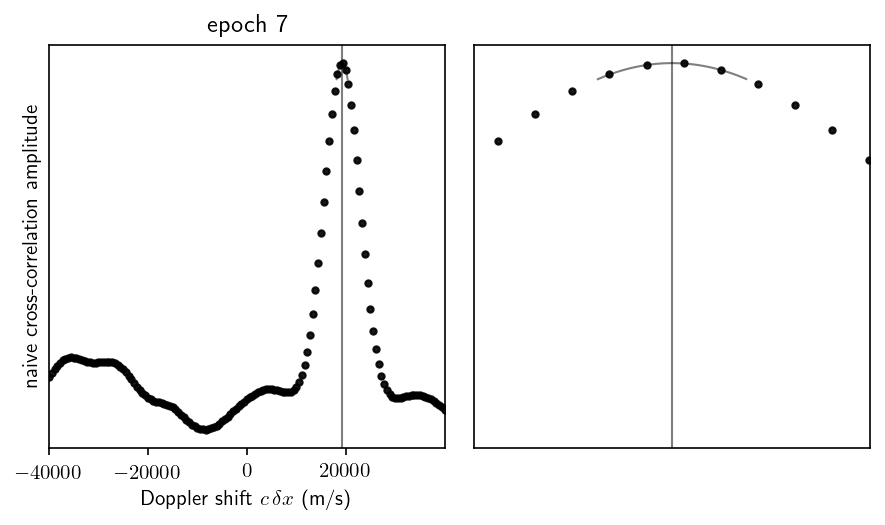

In [13]:
# plot the CCF for one epoch
def plot_ccf(doppler, ccs, ddp, ccp, ylabel):
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)
    for ax in axes:
        ax.axvline(c * doppler, color="k", alpha=0.5, lw=1)
        ax.plot(c * ddp, ccp, "k-", alpha=0.5, lw=1)
        ax.plot(c * dopplers, ccs, "k.", alpha=0.9)
    axes[0].set_xlim(np.min(c * dopplers), np.max(c * dopplers))
    axes[1].set_xlim(c * doppler - 4. * c * Delta_x, c * doppler + 4. * c * Delta_x)
    axes[0].set_xlabel(r"Doppler shift $c\,\delta x$ (m/s)")
    axes[0].get_yaxis().set_ticks([])
    axes[1].get_xaxis().set_ticks([])
    axes[0].set_ylabel(ylabel)
    axes[0].set_title("epoch {}".format(j))
    return fig
fig = plot_ccf(best_doppler, ccs, ddp, ccp, r"naive cross-correlation amplitude")
fig.savefig()

In [14]:
# get all the CCF RVs for all epochs
best_ccf_dopplers = get_all_ccf_rvs(ys, xs)

Text(0.5, 1.0, 'naive (but normalized) cross-correlation RVs')

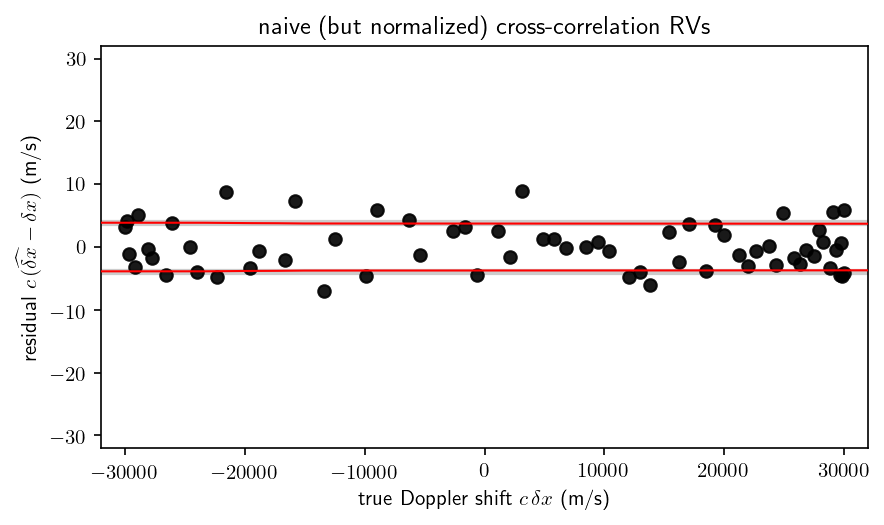

In [15]:
# plot all the RV residuals vs true RVs
def plot_resids(rs):
    resids = rs - np.mean(rs)
    plt.plot(c * dopplers,  c / np.sqrt(doppler_infos), "r-", lw=1, zorder=100)
    plt.plot(c * dopplers, -c / np.sqrt(doppler_infos), "r-", lw=1, zorder=100)
    plt.axhline(np.percentile(resids, 84.), color="k", alpha=0.2, lw=3)
    plt.axhline(np.percentile(resids, 16.), color="k", alpha=0.2, lw=3)
    plt.scatter(c * true_dopplers, resids, marker="o", color="k", alpha=0.9)
    plt.xlim(-3.2e4, 3.2e4)
    plt.ylim(-32., 32.)
    plt.xlabel("true Doppler shift $c\,\delta x$ (m/s)")
    plt.ylabel("residual $c\,(\widehat{\delta x} - \delta x)$ (m/s)")
plot_resids(c * (best_ccf_dopplers - true_dopplers))
plt.title("naive (but normalized) cross-correlation RVs")

In [16]:
# define functions to get maximum-likelihood RVs

def ln_likelihood(fs, ys, ivars):
    return -0.5 * np.sum(ivars * (ys - fs) ** 2)

def ln_likelihood_function(dopplers, xs, ys, ivars):
    tys = np.atleast_2d(ys)
    tivars = np.atleast_2d(ys)
    assert tys.shape == tivars.shape
    J = len(tys)
    I = len(dopplers)
    llfs = np.zeros((J, I))
    for i,doppler in enumerate(dopplers):
        fs = true_spectrum(xs, doppler)
        for j in range(J):
            llfs[j, i] = ln_likelihood(fs, tys[j], ivars[j])
    return llfs

def get_all_llf_rvs(ys, xs, y_ivars):
    """
    ## Bugs:
    - Magic numbers; relies on global variables R, c.
    - Could be sped up enormously by caching the templates it makes over and over!
    """
    J = len(ys)
    assert len(xs) == len(ys[0])
    assert len(y_ivars) == len(ys)
    assert len(y_ivars[0]) == len(ys[0])
    dopplers = np.arange(-4.e4/c, 4.e4/c, 0.25/R) # MAGIC
    best_dopplers = np.zeros(J)
    lls = ln_likelihood_function(dopplers, xs, ys, y_ivars)
    for j in range(J):
        best_dopplers[j] = hogg_parabola_trick(lls[j], dopplers)
    return best_dopplers

In [17]:
# get the ML RV for one epoch
llfs = ln_likelihood_function(dopplers, xs, ys[j], y_ivars_empirical[j])[0]
ddp = np.arange(true_dopplers[j] - 0.5 / R, true_dopplers[j] + 0.5 / R, 0.01 / R)
best_doppler, llp = hogg_parabola_trick(llfs, dopplers, ddp)
print(best_doppler)

6.415330719353392e-05


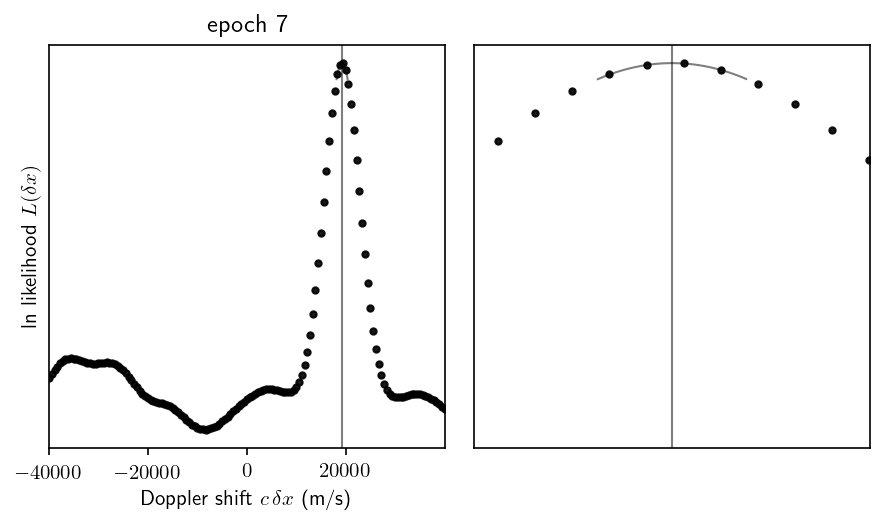

In [18]:
# plot the LF vs Doppler shift for one epoch
plot_ccf(best_doppler, llfs, ddp, llp, r"ln likelihood $L(\delta x)$")

In [19]:
# get all ML RVs for all epochs
best_llf_dopplers = get_all_llf_rvs(ys, xs, y_ivars_empirical)

Text(0.5, 1.0, 'maximum-likelihood RVs')

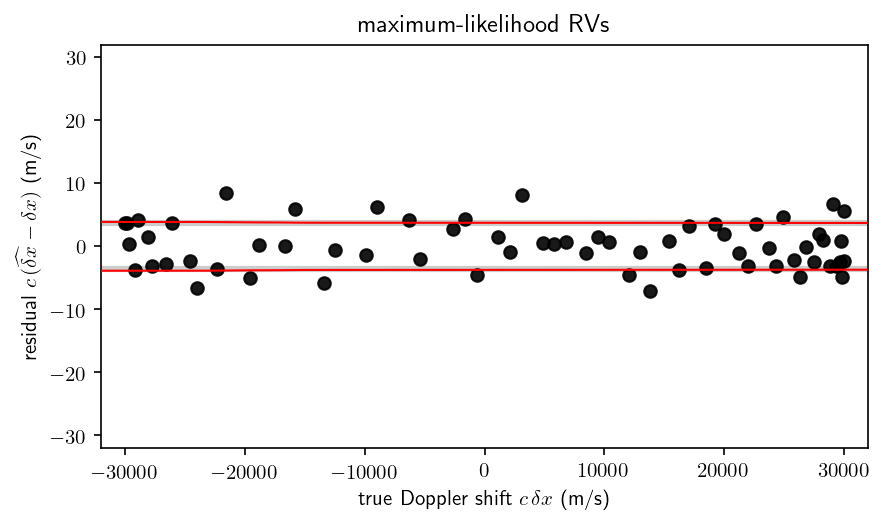

In [20]:
# plot the residuals of the ML RVs vs true RV
plot_resids(c * (best_llf_dopplers - true_dopplers))
plt.title("maximum-likelihood RVs")

In [40]:
# define all the functions you need to do binary-mask operations and fitting

def deduplicate_mask(ls, ws):
    """
    This might have to be run a few times!
    """
    dls, dws = ls.copy(), ws.copy()
    for j in range(len(dls) - 1):
        if (dls[j+1] - dls[j]) < 0.5 * (dws[j+1] + dws[j]):
            dls[j] = (dws[j+1] * dls[j+1] + dws[j] * dls[j]) / (dws[j+1] + dws[j])
            dws[j] = dws[j+1] + dws[j]
            dls[j+1] = -1.0
            dws[j+1] = 0.0
    good = dls > 0.
    return dls[good], dws[good]

def make_binary_mask(xs, lxs=line_xs, lews=line_ews, sigma=sigma_x):
    """
    ## Bugs:
    - depends on external variables, including the inputs and `c`.
    - magic numbers.
    - de-duplication is a hack
    """
    strong = lews > 1.e-6 # magic; made up
    margin = 4.e4 / c # magic
    inside = (line_xs > np.min(xs) + margin) * \
             (line_xs < np.max(xs) - margin)
    bmask_lines = 1. * lxs[strong * inside]
    bmask_widths = 0.25 * lews[strong * inside] # magic; made up
    I = np.argsort(bmask_lines)
    bmask_lines = bmask_lines[I]
    bmask_widths = bmask_widths[I]
    bmask_lines, bmask_widths = deduplicate_mask(bmask_lines, bmask_widths)
    bmask_lines, bmask_widths = deduplicate_mask(bmask_lines, bmask_widths)
    return bmask_lines, bmask_widths

def discrete_cross_correlation(x1s, y1s, x2s, y2s):
    """
    interpolate onto the x1 locations from the x2 locations and sum
    """
    inside = (x1s > np.min(x2s))* (x1s < np.max(x2s))
    foo = interp.interp1d(x2s, y2s, kind="cubic")
    return np.sum(y1s[inside] * foo(x1s[inside])) / np.sqrt(np.sum(y1s[inside] ** 2))

def ccf_with_binary_mask(dopplers, xs, ys, bmask, oversample=5):
    """
    Because the binary mask is a discrete set of tiny windows, this operation
    is done as a numerical integration, using `discrete_cross_correlation()`.
    """
    bmask_lines, bmask_widths = bmask
    grid = np.arange(-0.5 + 0.5 / oversample, 0.5, 1.0 / oversample)
    locations = (bmask_lines[:, None] + grid[None, :]).flatten()
    weights = (bmask_widths[:, None] * np.ones_like(grid)[None, :] / oversample).flatten()
    bccfs = np.zeros_like(dopplers)
    for i, doppler in enumerate(dopplers):
        bccfs[i] = discrete_cross_correlation(locations + doppler, weights, xs, ys)
    return bccfs

def get_all_bccf_rvs_wrong(ys, xs, bmask):
    """
    ## Bugs:
    - Deliberately wrong -- it optimizes rather than fits.
    - Magic numbers; relies on global variables R, c.
    """
    N = len(ys)
    assert len(xs) == len(ys[0])
    dopplers = np.arange(-4.e4/c, 4.e4/c, 0.25/R) # MAGIC
    best_dopplers = np.zeros(N)
    for j in range(N):
        ccs = ccf_with_binary_mask(dopplers, xs, ys[j], bmask)
        best_dopplers[j] = hogg_parabola_trick(-1. * ccs, dopplers)
    return best_dopplers

def gaussian_trick(yys, xxs, sigma):
    yyys = np.zeros_like(yys)
    for i, x in enumerate(xxs):
        foo = np.exp(-0.5 * (xxs - x) ** 2 / sigma ** 2)
        weights = np.ones_like(foo)
        weights[np.abs(xxs - x) > 3. * sigma] = 0.
        yyys[i] = cross_correlation(foo, yys, weights)
    return hogg_parabola_trick(yyys, xxs)

def get_all_bccf_rvs(ys, xs, bmask):
    """
    ## Bugs:
    - Hard-set Gaussian fitting function.
    - Magic numbers; relies on global variables `R, c, sigma_x`.
    """
    N = len(ys)
    assert len(xs) == len(ys[0])
    dopplers = np.arange(-4.e4/c, 4.e4/c, 0.25/R) # MAGIC
    best_dopplers = np.zeros(N)
    for j in range(N):
        ccs = ccf_with_binary_mask(dopplers, xs, ys[j], bmask)
        best_dopplers[j] = gaussian_trick(-1. * ccs, dopplers, sigma_x)
    return best_dopplers

In [41]:
# make the binary mask, which depends on the x range of the data
bmask = make_binary_mask(xs)

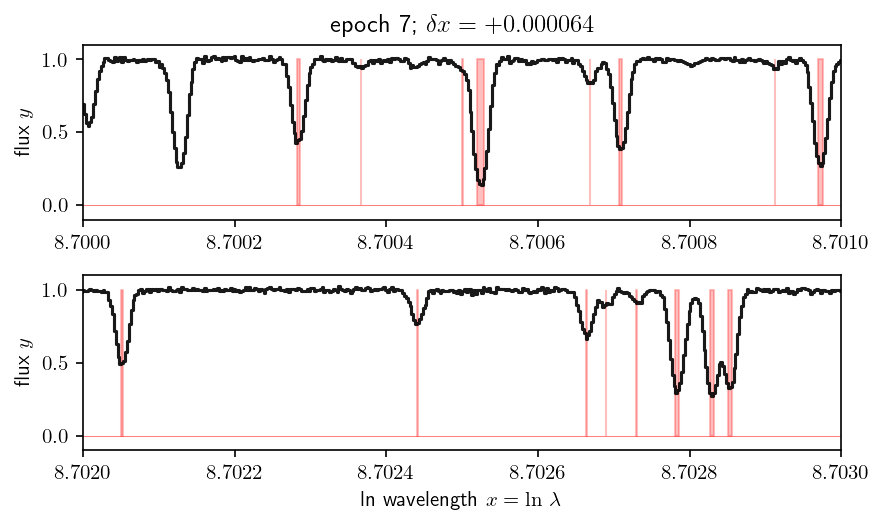

In [51]:
# visualize the binary mask
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
bl, bw = bmask
for ax in axes:
    ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.ticklabel_format(useOffset=False)
    for l, w in zip(bl, bw):
        ax.fill_between([l - 0.5 * w + best_doppler, l + 0.5 * w + best_doppler], [1., 1.],
                        color="r", alpha=0.25)
    ax.axhline(0., color="r", alpha=0.5, lw=0.5)
axes[0].set_xlim(8.700, 8.701)
axes[1].set_xlim(8.702, 8.703)
axes[0].set_ylim(-0.1, 1.1)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("epoch {}; $\delta x = {:+f}$".format(j, true_dopplers[j]))
fig.savefig("binarymask.png")

In [43]:
# get the binary-mask CCF at one epoch
bccs = ccf_with_binary_mask(dopplers, xs, ys[j], bmask)
best_doppler, bccp = hogg_parabola_trick(-1. * bccs, dopplers, ddp)

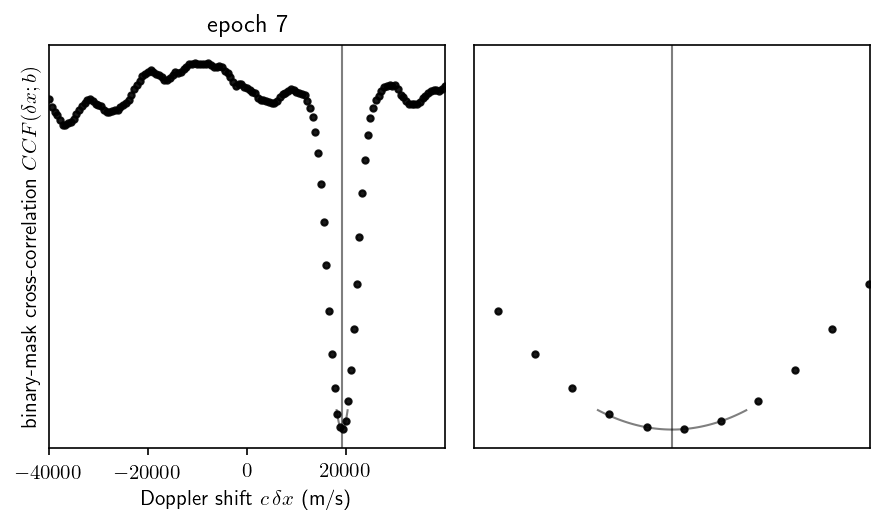

In [44]:
# plot the binary-mask CCF at one epoch
plot_ccf(best_doppler, bccs, ddp, -bccp, r"binary-mask cross-correlation $CCF(\delta x; b)$")

In [45]:
# get the (wrongly optimized) binary mask CCF RVs at all epochs
best_wrong_bccf_dopplers = get_all_bccf_rvs_wrong(ys, xs, bmask)

Text(0.5, 1.0, 'wrongly optimized binary-mask cross-correlation radial velocities')

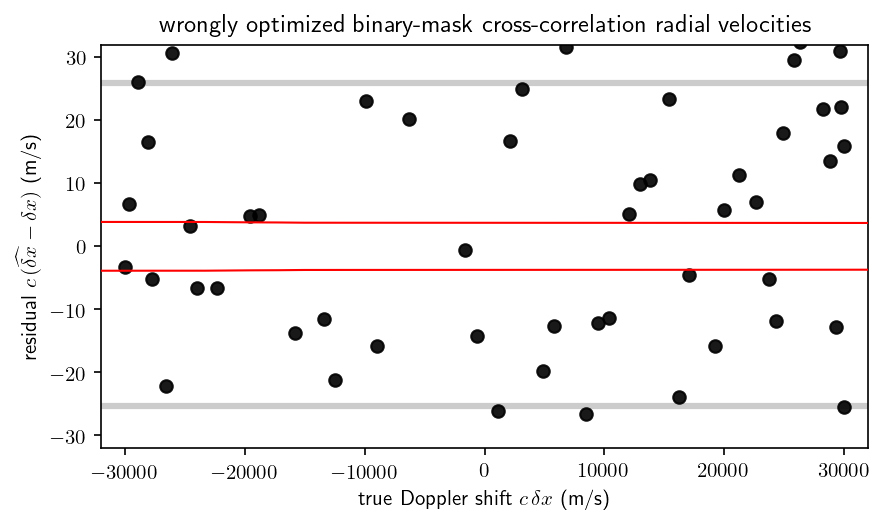

In [46]:
# plot the residuals of the wrongly optimized binary-mask CCF RVs vs true RV
plot_resids(c * (best_wrong_bccf_dopplers - true_dopplers))
plt.title("wrongly optimized binary-mask cross-correlation radial velocities")

In [47]:
# now get the correctly-fit binary-mask CCF RVs for all epochs
best_bccf_dopplers = get_all_bccf_rvs(ys, xs, bmask)

Text(0.5, 1.0, 'Gaussian-fit binary-mask cross-correlation radial velocities')

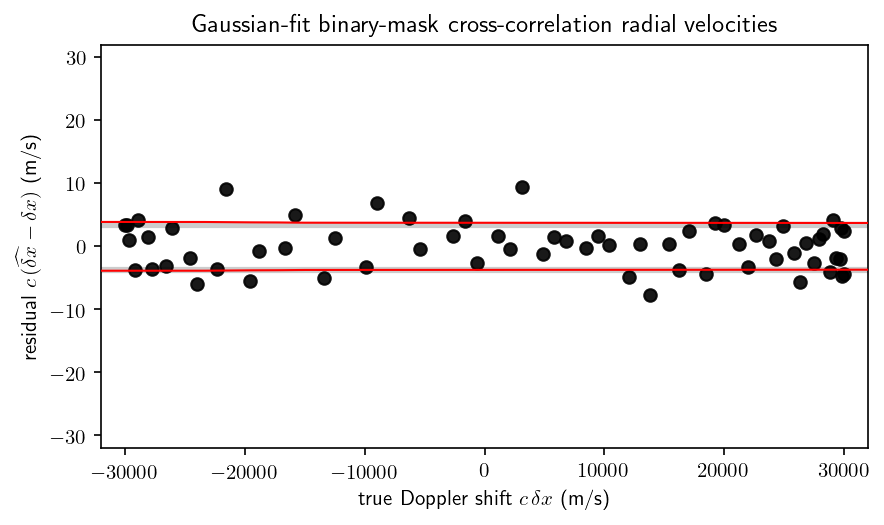

In [48]:
# plot the residuals of the correctly-fit binary-mask RVs vs true RV
plot_resids(c * (best_bccf_dopplers - true_dopplers))
plt.title("Gaussian-fit binary-mask cross-correlation radial velocities")

In [30]:
def empirical_spectra(xs, doppler, ys, dopplers):
    """
    ## Bugs:
    - This function makes a ridiculous number of dangerous assumptions.
      For example: That the xs of the spectra are all identical.
    - The zeroing out of spectrum at the edges is ridiculous.
    """
    margin = 4.e4 / c
    fs = np.zeros_like(ys)
    for j, (tyy, dd) in enumerate(zip(ys, dopplers)):
        yy = 1. * tyy
        yy[xs < (np.min(xs) + margin + dd)] = 1.0
        yy[xs > (np.max(xs) - margin + dd)] = 1.0
        fs[j] += interp.interp1d(xs - dd, yy, kind="cubic", assume_sorted=True,
                              bounds_error=False, fill_value=1.)(xs - doppler)
    return fs

def empirical_ccf(dopplers, xs, ys, current_best_dopplers, weights=None, normalize=True, loo=True):
    tys = np.atleast_2d(ys)
    if weights is None:
        weights = np.ones_like(tys)
    weights = np.atleast_2d(weights)
    I = len(dopplers)
    J = len(tys)
    assert tys.shape == weights.shape
    ccfs = np.zeros((J, I))
    for i,doppler in enumerate(dopplers):
        fss = empirical_spectra(xs, doppler, ys, current_best_dopplers)
        for j in range(J):
            if loo:
                fs = np.mean(fss[np.arange(J) != j], axis=0)
            else:
                fs = np.mean(fss, axis=0)
            ccfs[j,i] = cross_correlation(fs, tys[j], weights[j], normalize=normalize)
    return ccfs

def get_all_empirical_ccf_rvs(ys, xs, first_guess, normalize=True, loo=True):
    """
    ## Bugs:
    - Magic numbers; relies on global variables R, c.
    - Could be sped up enormously by caching the templates it makes over and over!
    """
    J = len(ys)
    assert len(xs) == len(ys[0])
    dopplers = np.arange(-4.e4/c, 4.e4/c, 0.25/R) # MAGIC
    best_dopplers = first_guess - np.median(first_guess)
    ccs = empirical_ccf(dopplers, xs, ys, best_dopplers, normalize=normalize, loo=loo)
    for j in range(J):
        best_dopplers[j] = hogg_parabola_trick(ccs[j], dopplers)
    return best_dopplers

Text(0.5, 1.0, 'epoch 7; $\\delta x = +0.000064$')

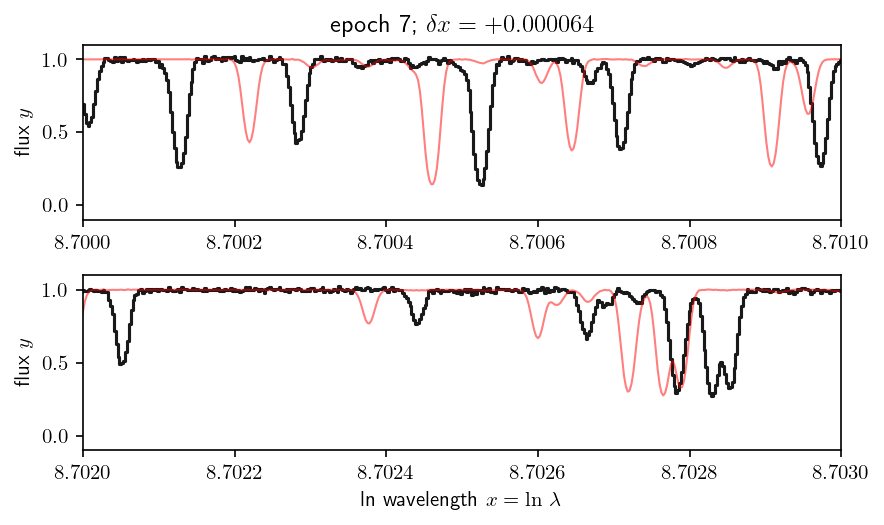

In [31]:
# zoom in on one epoch and compare it to the template.
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(xs, np.mean(empirical_spectra(xs, 0., ys, true_dopplers), axis=0), "r-", alpha=0.5, lw=1)
    ax.ticklabel_format(useOffset=False)
axes[0].set_xlim(8.700, 8.701)
axes[1].set_xlim(8.702, 8.703)
axes[0].set_ylim(-0.1, 1.1)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("epoch {}; $\delta x = {:+f}$".format(j, true_dopplers[j]))

In [32]:
# get all the CCF RVs for all epochs
# Check out the crappy initialization!
best_empirical_ccf_dopplers = get_all_empirical_ccf_rvs(ys, xs, best_wrong_bccf_dopplers)
best_empirical_ccf_dopplers = get_all_empirical_ccf_rvs(ys, xs, best_empirical_ccf_dopplers)
best_empirical_ccf_dopplers = get_all_empirical_ccf_rvs(ys, xs, best_empirical_ccf_dopplers)

Text(0.5, 1.0, 'empirical-template cross-correlation radial velocities')

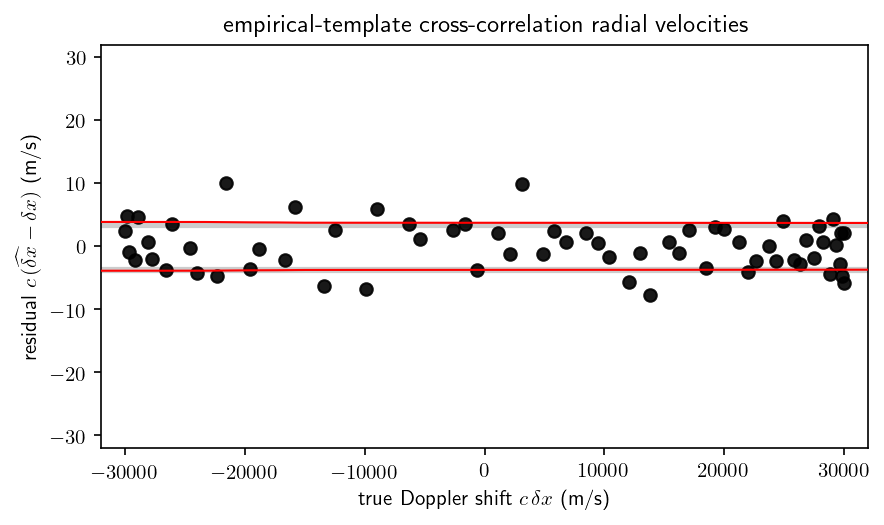

In [33]:
resids = c * (best_empirical_ccf_dopplers - true_dopplers)
plot_resids(resids)
plt.title("empirical-template cross-correlation radial velocities")